In [1]:
from __future__ import print_function
import os
#import cPickle as pickle
import pickle
from copy import copy
import numpy as np
import h5py
import importlib

#importing modules from other files
module_name = 'load_data'
module = importlib.import_module(module_name)
load_stdata = getattr(module, 'load_stdata')
stat = getattr(module, 'stat')


module_name = 'STMatrix'
module = importlib.import_module(module_name)
STMatrix = getattr(module, 'STMatrix')


module_name = 'minmax_normalization'
module = importlib.import_module(module_name)
MinMaxNormalization = getattr(module, 'MinMaxNormalization')

module_name = "test"
module = importlib.import_module(module_name)
remove_incomplete_days = getattr(module, 'remove_incomplete_days')
timestamp2vec = getattr(module, 'timestamp2vec')

module_name = 'config'
module = importlib.import_module(module_name)
config = getattr(module, 'Config')
DATAPATH = config().DATAPATH


In [2]:
DATAPATH = '../../data/TaxiBJ/'

### Function 1

The load_holiday function reads a list of holiday dates from a text file and compares them to a given array of timeslots. It returns a binary array where each element corresponds to a timeslot, with a value of 1 if the timeslot corresponds to a holiday date and 0 otherwise. The function also prints the total number of holiday timeslots found.

In [3]:
filename = "../../data/TaxiBJ/BJ_Holiday.txt"
values = [] 
with open(filename, "r") as f:
  lines = f.readlines()

timeslots = []
for line in lines:
  values.append(line.strip())
print(values)

['20130101', '20130102', '20130103', '20130209', '20130210', '20130211', '20130212', '20130213', '20130214', '20130215', '20130404', '20130405', '20130406', '20130429', '20130430', '20130501', '20130610', '20130611', '20130612', '20130919', '20130920', '20130921', '20131001', '20131002', '20131003', '20131004', '20131005', '20131006', '20131007', '20140101', '20140131', '20140201', '20140202', '20140203', '20140204', '20140205', '20140206', '20140405', '20140406', '20140407', '20140501', '20140502', '20140503', '20140531', '20140601', '20140602', '20140906', '20140907', '20140908', '20141001', '20141002', '20141003', '20141004', '20141005', '20141006', '20141007', '20150101', '20150102', '20150103', '20150218', '20150219', '20150220', '20150221', '20150222', '20150223', '20150224', '20150404', '20150405', '20150406', '20150501', '20150502', '20150503', '20150620', '20150621', '20150622', '20150903', '20150904', '20150905', '20150926', '20150927', '20151001', '20151002', '20151003', '20

In [4]:
def load_holiday(timeslots, fname=None):
    if fname is None:
        fname = os.path.join(DATAPATH, 'BJ_Holiday.txt')
    # print(fname)
    holidays = []
    with open(fname, 'r') as f:
        for line in f:
            holidays.append(line.strip())
    
    H = np.zeros(len(timeslots))
    for i, slot in enumerate(timeslots):
        if slot[:8] in holidays:
            H[i] = 1
    
    print(H.sum())
    return H[:, None]

# Define your 'timeslots' array here with the appropriate values

timeslots = np.array(timeslots)
load_holiday(timeslots)


0.0


array([], shape=(0, 1), dtype=float64)

In [5]:
from datetime import datetime

date_strings = [
    "20130101", "20130102", "20130103", "20130209", "20130210",
    "20130211", "20130212", "20130213", "20130214", "20130215",
    "20130404", "20130405", "20130406", "20130429", "20130430",
    "20130501", "20130610"
]

for date_string in date_strings:
    date = datetime.strptime(date_string, "%Y%m%d")
    day_of_week = date.strftime("%A")
    print(f"{date_string}: {day_of_week}")

20130101: Tuesday
20130102: Wednesday
20130103: Thursday
20130209: Saturday
20130210: Sunday
20130211: Monday
20130212: Tuesday
20130213: Wednesday
20130214: Thursday
20130215: Friday
20130404: Thursday
20130405: Friday
20130406: Saturday
20130429: Monday
20130430: Tuesday
20130501: Wednesday
20130610: Monday


### Function 2

This Python function, load_meteorol, is designed to load meteorological data for a given set of timeslots. It takes two arguments: timeslots, which represents the predicted timeslots for which you want to load meteorological data, and fname (defaulting to a specific file path), which is the location of the HDF5 file containing the meteorological data.

Inside the function, it opens the HDF5 file, extracts datasets for timeslots, wind speed, weather conditions, and temperature. It then maps the timeslots to their corresponding indices, retrieves the meteorological data for the previous timeslot of each predicted timeslot, scales the data to a 0-1 range, and finally concatenates these attributes into a single array named merge_data.

This function essentially prepares and preprocesses meteorological data for use in some downstream analysis or modeling.

In [6]:
f = h5py.File('../../data/TaxiBJ/BJ_Meteorology.h5', 'r')
keys = f.keys()
keys

<KeysViewHDF5 ['Temperature', 'Weather', 'WindSpeed', 'date']>

⛈️ `Weather:` a 2D matrix, each of which is a one-hot vector (dim=17).

In [7]:
import h5py

# Open the HDF5 file
with h5py.File('../../data/TaxiBJ/BJ_Meteorology.h5', 'r') as file:
    # Assuming 'Weather' is a group or dataset inside the HDF5 file
    if 'Weather' in file:
        # Access the data inside the 'Weather' dataset
        weather_data = file['Weather'][:]

        # show unique values
        print(np.unique(weather_data))
        print(weather_data.shape)
        
        # Now, 'weather_data' contains the data from the 'Weather' dataset
        print(weather_data)

[0. 1.]
(59006, 17)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# count the number of occurrences of 1 in each dimension
print(np.count_nonzero(weather_data == 1, axis=0))

[32031  8290  3382   721  1831   384    52    64  2325    98   140   190
     0   120  9332     4    42]


In [9]:
import matplotlib as plt
import h5py
import numpy as np
import matplotlib.pyplot as plt

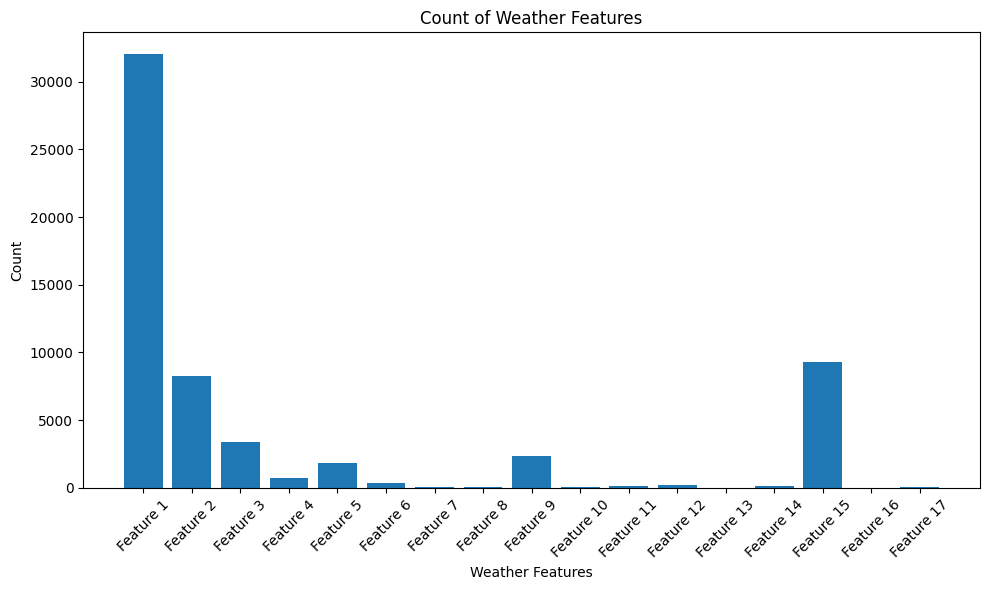

In [10]:
import matplotlib.pyplot as plt

# Open the HDF5 file
with h5py.File('../../data/TaxiBJ/BJ_Meteorology.h5', 'r') as file:
    # Assuming 'Weather' is a group or dataset inside the HDF5 file
    if 'Weather' in file:
        # Access the data inside the 'Weather' dataset
        weather_data = file['Weather'][:]

        # Calculate the count of each category (weather feature) over time
        category_counts = np.sum(weather_data, axis=0)

        # Create a bar plot
        plt.figure(figsize=(10, 6))
        categories = [f'Feature {i+1}' for i in range(category_counts.shape[0])]
        plt.bar(categories, category_counts)
        plt.xlabel('Weather Features')
        plt.ylabel('Count')
        plt.title('Count of Weather Features')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


🌡️ `Temperature:` a list of continuous value, of which the i^{th} value is temperature at the timeslot date[i].

In [11]:
# Open the HDF5 file
with h5py.File('../../data/TaxiBJ/BJ_Meteorology.h5', 'r') as file:
    # Assuming 'Weather' is a group or dataset inside the HDF5 file
    if 'Weather' in file:
        # Access the data inside the 'Weather' dataset
        weather_data = file['Temperature'][:]

        # show unique values
        print(np.unique(weather_data))
        print(weather_data.shape)
        
        # Now, 'weather_data' contains the data from the 'Weather' dataset
        print(weather_data)

[-15.1 -15.  -14.9 -14.8 -14.7 -14.6 -14.5 -14.4 -14.3 -14.1 -14.  -13.9
 -13.8 -13.7 -13.6 -13.5 -13.4 -13.3 -13.2 -13.  -12.6 -11.9 -11.5 -11.4
 -11.3 -11.2 -11.1 -11.  -10.9 -10.8 -10.7 -10.6 -10.5 -10.3 -10.2 -10.1
 -10.   -9.9  -9.8  -9.6  -9.5  -9.4  -9.3  -9.2  -9.1  -9.   -8.9  -8.8
  -8.7  -8.6  -8.5  -8.4  -8.3  -8.2  -8.1  -8.   -7.9  -7.8  -7.7  -7.6
  -7.5  -7.4  -7.3  -7.2  -7.1  -7.   -6.9  -6.8  -6.7  -6.6  -6.5  -6.4
  -6.3  -6.2  -6.1  -6.   -5.9  -5.8  -5.7  -5.6  -5.5  -5.4  -5.3  -5.2
  -5.1  -5.   -4.9  -4.8  -4.7  -4.6  -4.5  -4.4  -4.3  -4.2  -4.1  -4.
  -3.9  -3.8  -3.7  -3.6  -3.5  -3.4  -3.3  -3.2  -3.1  -3.   -2.9  -2.8
  -2.7  -2.6  -2.5  -2.4  -2.3  -2.2  -2.1  -2.   -1.9  -1.8  -1.7  -1.6
  -1.5  -1.4  -1.3  -1.2  -1.1  -1.   -0.9  -0.8  -0.7  -0.6  -0.5  -0.4
  -0.3  -0.2  -0.1   0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8
   0.9   1.    1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.
   2.1   2.2   2.3   2.4   2.5   2.6   2.7   2.8   2.

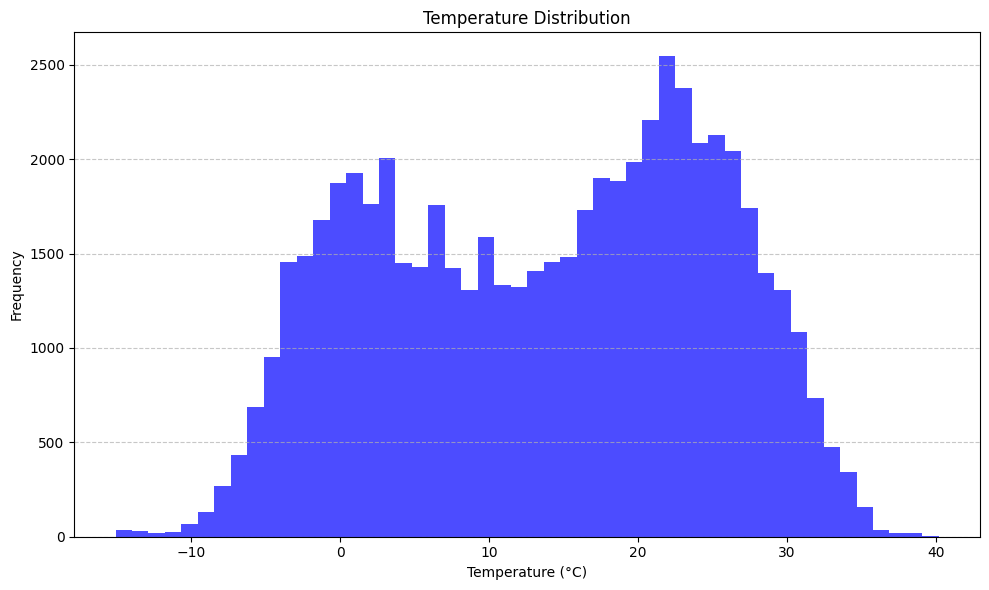

In [12]:
import matplotlib.pyplot as plt

# Open the HDF5 file
with h5py.File('../../data/TaxiBJ/BJ_Meteorology.h5', 'r') as file:
    # Assuming 'Temperature' is a dataset inside the HDF5 file
    if 'Temperature' in file:
        # Access the temperature data
        temperature_data = file['Temperature'][:]

        # Create a histogram plot
        plt.figure(figsize=(10, 6))
        plt.hist(temperature_data, bins=50, color='blue', alpha=0.7)
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Frequency')
        plt.title('Temperature Distribution')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


In [13]:
filename = "../../data/TaxiBJ/BJ_Holiday.txt"
values = [] 
with open(filename, "r") as f:
  lines = f.readlines()

timeslots = []
for line in lines:
  values.append(line.strip())
print(values)

['20130101', '20130102', '20130103', '20130209', '20130210', '20130211', '20130212', '20130213', '20130214', '20130215', '20130404', '20130405', '20130406', '20130429', '20130430', '20130501', '20130610', '20130611', '20130612', '20130919', '20130920', '20130921', '20131001', '20131002', '20131003', '20131004', '20131005', '20131006', '20131007', '20140101', '20140131', '20140201', '20140202', '20140203', '20140204', '20140205', '20140206', '20140405', '20140406', '20140407', '20140501', '20140502', '20140503', '20140531', '20140601', '20140602', '20140906', '20140907', '20140908', '20141001', '20141002', '20141003', '20141004', '20141005', '20141006', '20141007', '20150101', '20150102', '20150103', '20150218', '20150219', '20150220', '20150221', '20150222', '20150223', '20150224', '20150404', '20150405', '20150406', '20150501', '20150502', '20150503', '20150620', '20150621', '20150622', '20150903', '20150904', '20150905', '20150926', '20150927', '20151001', '20151002', '20151003', '20

In [14]:
# def load_meteorol(timeslots, fname=os.path.join(DATAPATH, 'TaxiBJ', 'BJ_Meteorology.h5')):
'''
timeslots: the predicted timeslots
In real-world, we dont have the meteorol data in the predicted timeslot, instead, we use the meteoral at previous timeslots, i.e., slot = predicted_slot - timeslot (you can use predicted meteorol data as well)
'''
# read timeslots 

# Open the HDF5 file
f = h5py.File('../../data/TaxiBJ/BJ_Meteorology.h5', 'r')

# Access the datasets directly using indexing
Timeslot = f['date'][:]
WindSpeed = f['WindSpeed'][:]
Weather = f['Weather'][:]
Temperature = f['Temperature'][:]

# Debugging
print("Timeslot:", Timeslot)

# Close the file
# f.close()

# Rest of your code
M = dict()  # map timeslot to index
for i, slot in enumerate(Timeslot):
    M[slot] = i

WS = []  # WindSpeed
WR = []  # Weather
TE = []  # Temperature
for slot in Timeslot:
    predicted_id = M[slot]
    cur_id = predicted_id - 1
    WS.append(WindSpeed[cur_id])
    WR.append(Weather[cur_id])
    TE.append(Temperature[cur_id])

WS = np.asarray(WS)
WR = np.asarray(WR)
TE = np.asarray(TE)

# 0-1 scale
WS = 1. * (WS - WS.min()) / (WS.max() - WS.min())
TE = 1. * (TE - TE.min()) / (TE.max() - TE.min())

print("shape: ", WS.shape, WR.shape, TE.shape)

# concatenate all these attributes
merge_data = np.hstack([WR, WS[:, None], TE[:, None]])


Timeslot: [b'2013020105' b'2013020106' b'2013020107' ... b'2016061335' b'2016061336'
 b'2016061337']
shape:  (59006,) (59006, 17) (59006,)


### Function 3

In [15]:
def load_data(T=48, nb_flow=2, len_closeness=None, len_period=None, len_trend=None,
              len_test=None, preprocess_name='preprocessing.pkl',
              meta_data=True, meteorol_data=True, holiday_data=True):
    """
    """
    assert(len_closeness + len_period + len_trend > 0)
    # load data
    # 13 - 16
    data_all = []
    timestamps_all = list()
    for year in range(13, 17):
        fname = os.path.join(
            DATAPATH, 'TaxiBJ', 'BJ{}_M32x32_T30_InOut.h5'.format(year))
        print("file name: ", fname)
        stat(fname)
        data, timestamps = load_stdata(fname)
        # print(timestamps)
        # remove a certain day which does not have 48 timestamps
        data, timestamps = remove_incomplete_days(data, timestamps, T)
        data = data[:, :nb_flow]
        data[data < 0] = 0.
        data_all.append(data)
        timestamps_all.append(timestamps)
        print("\n")

    # minmax_scale
    data_train = np.vstack(copy(data_all))[:-len_test]
    print('train_data shape: ', data_train.shape)
    mmn = MinMaxNormalization()
    mmn.fit(data_train)
    data_all_mmn = [mmn.transform(d) for d in data_all]

    fpkl = open(preprocess_name, 'wb')
    for obj in [mmn]:
        pickle.dump(obj, fpkl)
    fpkl.close()

    XC, XP, XT = [], [], []
    Y = []
    timestamps_Y = []
    for data, timestamps in zip(data_all_mmn, timestamps_all):
        # instance-based dataset --> sequences with format as (X, Y) where X is
        # a sequence of images and Y is an image.
        st = STMatrix(data, timestamps, T, CheckComplete=False)
        _XC, _XP, _XT, _Y, _timestamps_Y = st.create_dataset(
            len_closeness=len_closeness, len_period=len_period, len_trend=len_trend)
        XC.append(_XC)
        XP.append(_XP)
        XT.append(_XT)
        Y.append(_Y)
        timestamps_Y += _timestamps_Y

    meta_feature = []
    if meta_data:
        # load time feature
        time_feature = timestamp2vec(timestamps_Y)
        meta_feature.append(time_feature)
    if holiday_data:
        # load holiday
        holiday_feature = load_holiday(timestamps_Y)
        meta_feature.append(holiday_feature)
    if meteorol_data:
        # load meteorol data
        meteorol_feature = load_meteorol(timestamps_Y)
        meta_feature.append(meteorol_feature)

    meta_feature = np.hstack(meta_feature) if len(
        meta_feature) > 0 else np.asarray(meta_feature)
    metadata_dim = meta_feature.shape[1] if len(
        meta_feature.shape) > 1 else None
    if metadata_dim < 1:
        metadata_dim = None
    if meta_data and holiday_data and meteorol_data:
        print('time feature:', time_feature.shape, 'holiday feature:', holiday_feature.shape,
              'meteorol feature: ', meteorol_feature.shape, 'mete feature: ', meta_feature.shape)

    XC = np.vstack(XC)
    XP = np.vstack(XP)
    XT = np.vstack(XT)
    Y = np.vstack(Y)
    print("XC shape: ", XC.shape, "XP shape: ", XP.shape,
          "XT shape: ", XT.shape, "Y shape:", Y.shape)

    XC_train, XP_train, XT_train, Y_train = XC[
        :-len_test], XP[:-len_test], XT[:-len_test], Y[:-len_test]
    XC_test, XP_test, XT_test, Y_test = XC[
        -len_test:], XP[-len_test:], XT[-len_test:], Y[-len_test:]
    timestamp_train, timestamp_test = timestamps_Y[
        :-len_test], timestamps_Y[-len_test:]

    X_train = []
    X_test = []
    for l, X_ in zip([len_closeness, len_period, len_trend], [XC_train, XP_train, XT_train]):
        if l > 0:
            X_train.append(X_)
    for l, X_ in zip([len_closeness, len_period, len_trend], [XC_test, XP_test, XT_test]):
        if l > 0:
            X_test.append(X_)
    print('train shape:', XC_train.shape, Y_train.shape,
          'test shape: ', XC_test.shape, Y_test.shape)

    if metadata_dim is not None:
        meta_feature_train, meta_feature_test = meta_feature[
            :-len_test], meta_feature[-len_test:]
        X_train.append(meta_feature_train)
        X_test.append(meta_feature_test)
    for _X in X_train:
        print(_X.shape, )
    print()
    for _X in X_test:
        print(_X.shape, )
    print()
    return X_train, Y_train, X_test, Y_test, mmn, metadata_dim, timestamp_train, timestamp_test


In [16]:
import os
import pickle
import numpy as np
from STMatrix import STMatrix
import datetime
#from utils import STMatrix, timestamp2vec, load_holiday, load_meteorol, MinMaxNormalization, load_stdata, remove_incomplete_days

DATAPATH = "C:\\Users\\user\\Desktop\\DeepST\\data\\TaxiBJ"  # Replace with your actual data path
T = 48
nb_flow = 2
len_closeness = 0
len_period = None
len_trend = None
len_test = None
preprocess_name = 'preprocessing.pkl'
meta_data = True
meteorol_data = True
holiday_data = True

len_closeness=3
len_trend=3
TrendInterval=7
len_period=3
PeriodInterval=1
# assert (len_closeness + len_period + len_trend > 0)

# Load data
data_all = []
timestamps_all = list()
for year in range(13, 17):
    fname = os.path.join(DATAPATH, 'BJ{}_M32x32_T30_InOut.h5'.format(year))
    print("file name: ", fname)
    data, timestamps = load_stdata(fname)
    data, timestamps = remove_incomplete_days(data, timestamps, T)
    data = data[:, :nb_flow]
    data[data < 0] = 0.
    data_all.append(data)
    timestamps_all.append(timestamps)
    print("\n")

# Minmax_scale
if len_test is not None:
    data_train = np.vstack(data_all[:-len_test])
else:
    data_train = np.vstack(data_all)
print('train_data shape: ', data_train.shape)
mmn = MinMaxNormalization()
mmn.fit(data_train)
data_all_mmn = [mmn.transform(d) for d in data_all]

fpkl = open(preprocess_name, 'wb')
for obj in [mmn]:
    pickle.dump(obj, fpkl)
fpkl.close()

file name:  C:\Users\user\Desktop\DeepST\data\TaxiBJ\BJ13_M32x32_T30_InOut.h5
data (4888, 2, 32, 32)
date (4888,)
This is load data from load_data.py
incomplete days:  [b'20130926']




file name:  C:\Users\user\Desktop\DeepST\data\TaxiBJ\BJ14_M32x32_T30_InOut.h5
data (4780, 2, 32, 32)
date (4780,)
This is load data from load_data.py
incomplete days:  [b'20140304', b'20140313', b'20140323', b'20140326', b'20140401', b'20140402', b'20140409', b'20140410', b'20140412', b'20140422', b'20140501', b'20140526', b'20140618', b'20140627']


file name:  C:\Users\user\Desktop\DeepST\data\TaxiBJ\BJ15_M32x32_T30_InOut.h5
data (5596, 2, 32, 32)
date (5596,)
This is load data from load_data.py
incomplete days:  [b'20150320', b'20150404', b'20150620']


file name:  C:\Users\user\Desktop\DeepST\data\TaxiBJ\BJ16_M32x32_T30_InOut.h5
data (7220, 2, 32, 32)
date (7220,)
This is load data from load_data.py
incomplete days:  [b'20151101', b'20151103', b'20151109', b'20151110', b'20151112', b'20151121', b'20151124', b'20151128', b'20151201', b'20151203', b'20151206', b'20151210', b'20151211', b'20151212', b'20151217', b'20151227', b'20151229', b'20160111', b'20160127', b'20160323', b'2016

In [17]:
XC, XP, XT = [], [], []
Y = []
timestamps_Y = []
for data, timestamps in zip(data_all_mmn, timestamps_all):
    print(data)
    print(timestamps)
    st = STMatrix(data, timestamps, T, CheckComplete=False)
    _XC, _XP, _XT, _Y, _timestamps_Y = st.create_dataset(
        len_closeness=len_closeness, len_period=len_period, len_trend=len_trend)
    XC.append(_XC)
    XP.append(_XP)
    XT.append(_XT)
    Y.append(_Y)
    timestamps_Y += _timestamps_Y
#print(timestamps_Y[:2])


meta_feature = []
if meta_data:
    time_feature = timestamp2vec(timestamps_Y)

    meta_feature.append(time_feature)
if holiday_data:
    holiday_feature = load_holiday(timestamps_Y)
    meta_feature.append(holiday_feature)
if meteorol_data:
    meteorol_feature = load_meteorol(timestamps_Y)
    meta_feature.append(meteorol_feature)

meta_feature = np.hstack(meta_feature) if len(
    meta_feature) > 0 else np.asarray(meta_feature)
metadata_dim = meta_feature.shape[1] if len(
    meta_feature.shape) > 1 else None
if metadata_dim < 1:
    metadata_dim = None
if meta_data and holiday_data and meteorol_data:
    print('time feature:', time_feature.shape, 'holiday feature:', holiday_feature.shape,
          'meteorol feature: ', meteorol_feature.shape, 'mete feature: ', meta_feature.shape)

XC = np.vstack(XC)
XP = np.vstack(XP)
XT = np.vstack(XT)
Y = np.vstack(Y)
print("XC shape: ", XC.shape, "XP shape: ", XP.shape,
      "XT shape: ", XT.shape, "Y shape:", Y.shape)

XC_train, XP_train, XT_train, Y_train = XC[
    :-len_test], XP[:-len_test], XT[:-len_test], Y[:-len_test]
XC_test, XP_test, XT_test, Y_test = XC[
    -len_test:], XP[-len_test:], XT[-len_test:], Y[-len_test:]
timestamp_train, timestamp_test = timestamps_Y[
    :-len_test], timestamps_Y[-len_test:]

X_train = []
X_test = []
for l, X_ in zip([len_closeness, len_period, len_trend], [XC_train, XP_train, XT_train]):
    if l > 0:
        X_train.append(X_)
for l, X_ in zip([len_closeness, len_period, len_trend], [XC_test, XP_test, XT_test]):
    if l > 0:
        X_test.append(X_)
print('train shape:', XC_train.shape, Y_train.shape,
      'test shape: ', XC_test.shape, Y_test.shape)

if metadata_dim is not None:
    meta_feature_train, meta_feature_test = meta_feature[
        :-len_test], meta_feature[-len_test:]
    X_train.append(meta_feature_train)
    X_test.append(meta_feature_test)
for _X in X_train:
    print(_X.shape, )
print()
for _X in X_test:
    print(_X.shape, )
print()


[[[[-1.         -0.96904025 -0.93653251 ... -0.98916409 -0.99845201
    -0.9380805 ]
   [-1.         -0.98297214 -0.9876161  ... -0.96594427 -0.98916409
    -0.85139319]
   [-1.         -0.98606811 -0.99226006 ... -0.97832817 -0.69349845
    -0.81888545]
   ...
   [-0.99845201 -0.99535604 -0.99380805 ... -0.9876161  -0.99071207
    -0.99535604]
   [-1.         -1.         -1.         ... -0.98606811 -1.
    -0.98916409]
   [-0.99845201 -1.         -1.         ... -0.97368421 -0.96904025
    -0.98916409]]

  [[-1.         -0.96749226 -0.93188854 ... -0.99071207 -0.99845201
    -0.94117647]
   [-1.         -0.98297214 -0.9876161  ... -0.96439628 -0.99071207
    -0.85603715]
   [-1.         -0.98606811 -0.99226006 ... -0.97678019 -0.68885449
    -0.81424149]
   ...
   [-0.99690402 -0.99535604 -0.99380805 ... -0.98916409 -0.98916409
    -0.99535604]
   [-1.         -1.         -1.         ... -0.98606811 -1.
    -0.98916409]
   [-0.99845201 -1.         -1.         ... -0.97058824 -0.967492

TypeError: strptime() argument 1 must be str, not bytes